In [1]:
import random
import seaborn as sns
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
from tqdm import tqdm
from scipy import stats
from typing import Literal

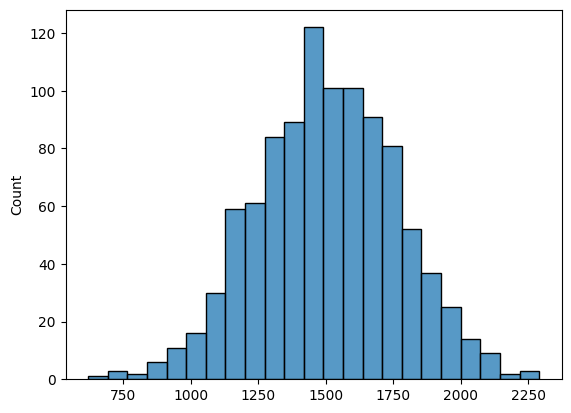

In [2]:
l = [x.round(-1) for x in list(np.random.normal(1500, 250, 1000))]
sns.histplot(l);

In [3]:
def get_prizes(entry_fee, entries, mod = 1):
    
    revenue = entry_fee * entries
    
    prize_dict = {
        5:   entries * 10 * mod,
        4.5: entries * 5 * mod,
        4:   entries * 2.5 * mod,
        3.5: entry_fee,
        3:   0,
        2.5: 0,
        2:   0,
        1.5: 0,
        1:   0,
        0.5: 0,
        0:   0,
    }
    # If the prize for 4/5 is less than the prize for 3.5/5 which is equal to the entry fee,
    # Then set the prize for 4/5 to the entry fee and get rid of the 3.5/5 prize
    if prize_dict[4] < prize_dict[3.5]:
        prize_dict[4] = entry_fee
        prize_dict[3.5] = 0
    
    # Guarantee that prizes will be what they would be if 10 players entered
    if entries < 10:
        prize_dict = {
            5:   10 * 10 * mod,
            4.5: 10 * 5 * mod,
            4:   entry_fee,
            3.5: 0,
            3:   0,
            2.5: 0,
            2:   0,
            1.5: 0,
            1:   0,
            0.5: 0,
            0:   0,
        }        
        
    # Under X ELO prize is equal to the prize for 4.5/5
    under_prize = prize_dict[4.5]
    
    return revenue, prize_dict, under_prize

def get_fixed_prizes(entry_fee, entries):
    
    revenue = entry_fee * entries
    
    prize_dict = {
        5:   200,
        4.5: 130,
        4:   60,
        3.5: 40,
        3:   0,
        2.5: 0,
        2:   0,
        1.5: 0,
        1:   0,
        0.5: 0,
        0:   0,
    }  
        
    # 2 Under X ELO prizes, $100, $50
    under_prize = 100 + 60
    
    return revenue, prize_dict, under_prize

def run_simulation(num_simulations, entries, 
                   revenue, prize_dict, under_prize, 
                   section: Literal['none', 'under', 'over'], cutoff: int):
    
    payouts_sim = {}
    scores_sim = {}    
    
    for simulation in range(0, num_simulations):

            players = ['p' + str(x) for x in list(range(1, entries + 1))]
            
            # Sample ELOs from normal distribution around 1500 with SD = 250
            if section == 'none':
                elos = random.sample(
                    [x.round(-1) for x in list(np.random.normal(1500, 250, 1000))], len(players))
            elif section == 'under':
                elos = random.sample(
                    [x.round(-1) for x in list(np.random.normal(1500, 250, 1000)) if x <= cutoff], len(players))
            elif section == 'over':
                elos = random.sample(
                    [x.round(-1) for x in list(np.random.normal(1500, 250, 1000)) if x > cutoff], len(players))
            
            elo_dict = dict(zip(players, elos))
    #         # Sort elo_dict by rating
    #         elo_dict = {k: v for k, v in sorted(elo_dict.items(), key = lambda item: item[1], reverse = True)}
            outcomes_dict = dict(zip(list(elo_dict.keys()), [[] for x in list(elo_dict.keys())]))

            for round_ in range(0, num_rounds):

                try:
                    possible_matchups = rankings
                except:
                    pass

                for matchup in range(0, int(entries/2)):

                    # Match based on ELO seeding for round 0, top half vs. bottom half
                    if round_ == 0:
                        elo_dict_sorted = {k: v for k, v in sorted(elo_dict.items(), key = lambda item: item[1], reverse = False)}
                        p1 = list(elo_dict_sorted.keys())[matchup]
                        p2 = list(elo_dict_sorted.keys())[matchup + int(len(players) / 2)]
                        
                    # For subsequent rounds, match based on ranking, random within same score
                    else:
                        p1 = possible_matchups[0]
                        possible_matchups.remove(p1)
                        try: 
                            # Try not to match with the same player
                            p2 = [x for x in possible_matchups if x not in [x[1] for x in outcomes_dict[p1]]][0]
                            possible_matchups.remove(p2)
                        except:
                            p2 = possible_matchups[0]
                            possible_matchups.remove(p2)

                    # Randomly increase or decrease a player's ELO by 100
                    p1_elo = elo_dict[p1] + np.random.randint(-100, 100)
                    p2_elo = elo_dict[p2] + np.random.randint(-100, 100)

                    # ELO formula model
                    n = abs(p1_elo - p2_elo)
                    odds = 10**(n/400)
                    prob = odds / (1 + odds)
                    l = [1] * round(prob * 100) + [0] * (100 - round(prob * 100))
                    
                    # Add 5 draw possibilities to the list of possibilities if ELO difference < 200 (~5%)
                    if abs(p1_elo - p2_elo) < 200:
                        l = l + [0.5] * 5
                    result = random.sample(l, 1)[0]

                    # Append results
                    if p1_elo >= p2_elo:
                        proj_winner = p1
                    else:
                        proj_winner = p2

                    if result == 0.5:
                        outcomes_dict[p1].append([0.5,        p2, p1_elo, p2_elo])
                        outcomes_dict[p2].append([0.5,        p1, p2_elo, p1_elo])
                    elif proj_winner == p1:
                        outcomes_dict[p1].append([result,     p2, p1_elo, p2_elo])
                        outcomes_dict[p2].append([1 - result, p1, p2_elo, p1_elo])
                    elif proj_winner == p2:
                        outcomes_dict[p1].append([1 - result, p2, p1_elo, p2_elo])
                        outcomes_dict[p2].append([result,     p1, p2_elo, p1_elo])

                scores = {k: sum([x[0] for x in v]) for (k, v) in outcomes_dict.items()}
                rankings = list({k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}.keys())

            prizes = {k:prize_dict[v] for (k, v) in scores.items()}
            payout = sum(prizes.values())
            payouts_sim[simulation] = payout
            scores_sim[simulation] = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Calculate profits, subtract under XXXX prize from revenue
    profits = {k: revenue - (v + under_prize) for (k, v) in payouts_sim.items()}
        
    return scores_sim, profits

def print_stats(entries, prize_dict, under_prize, profits, scores_sim):
    print('Entries:', entries)
    print('---')
    print('Prizes:', prize_dict)
    print('Under Prize:', under_prize)
    print()
    print('Mean profit:', '$' + str(round(np.mean(list(profits.values()))))),
    print('Min profit:', '$' + str(round(np.min(list(profits.values()))))),
    print('Max profit:', '$' + str(round(np.max(list(profits.values()))))),
    print('Mode profit:', '$' + str(round(stats.mode(list(profits.values())).mode))),
    print()
    print(f'5/5s in {num_simulations} simulations:', sum({k: len({k: v for k, v in v.items() if v == 5}) for k, v in scores_sim.items()}.values()))
    print()
    print('*****')
    print()

# Set global parameters

In [4]:
num_simulations = 1000
num_rounds = 5

# One section

In [5]:
# Set parameters
entry_fee = 45

for entries in [6, 10, 12, 14, 16, 20, 26, 30, 36, 40]:
    
#     revenue, prize_dict, under_prize = get_prizes(entry_fee, entries)
    revenue, prize_dict, under_prize = get_fixed_prizes(entry_fee, entries)

    scores_sim, profits = run_simulation(num_simulations, entries, 
                                         revenue, prize_dict, under_prize, 
                                         'none', np.nan)
    
    print_stats(entries, prize_dict, under_prize, profits, scores_sim)

Entries: 6
---
Prizes: {5: 200, 4.5: 130, 4: 60, 3.5: 40, 3: 0, 2.5: 0, 2: 0, 1.5: 0, 1: 0, 0.5: 0, 0: 0}
Under Prize: 160

Mean profit: $-75
Min profit: $-170
Max profit: $110
Mode profit: $-150

5/5s in 1000 simulations: 585

*****

Entries: 10
---
Prizes: {5: 200, 4.5: 130, 4: 60, 3.5: 40, 3: 0, 2.5: 0, 2: 0, 1.5: 0, 1: 0, 0.5: 0, 0: 0}
Under Prize: 160

Mean profit: $79
Min profit: $-50
Max profit: $290
Mode profit: $30

5/5s in 1000 simulations: 575

*****

Entries: 12
---
Prizes: {5: 200, 4.5: 130, 4: 60, 3.5: 40, 3: 0, 2.5: 0, 2: 0, 1.5: 0, 1: 0, 0.5: 0, 0: 0}
Under Prize: 160

Mean profit: $151
Min profit: $40
Max profit: $320
Mode profit: $120

5/5s in 1000 simulations: 563

*****

Entries: 14
---
Prizes: {5: 200, 4.5: 130, 4: 60, 3.5: 40, 3: 0, 2.5: 0, 2: 0, 1.5: 0, 1: 0, 0.5: 0, 0: 0}
Under Prize: 160

Mean profit: $210
Min profit: $90
Max profit: $370
Mode profit: $210

5/5s in 1000 simulations: 623

*****

Entries: 16
---
Prizes: {5: 200, 4.5: 130, 4: 60, 3.5: 40, 3: 0, 2.

# Two sections

In [ ]:
# Set parameters
entry_fee = 35
cutoff = 1600

for entries in [10, 16, 20, 26, 30]:
    
    u_revenue, u_prize_dict, u_under_prize = get_prizes(entry_fee, entries, 0.8)

    u_scores_sim, u_profits = run_simulation(num_simulations, entries, 
                                             u_revenue, u_prize_dict, u_under_prize, 
                                             'under', cutoff)
    
    o_revenue, o_prize_dict, o_under_prize = get_prizes(entry_fee, entries, 1.2)

    o_scores_sim, o_profits = run_simulation(num_simulations, entries, 
                                             o_revenue, o_prize_dict, o_under_prize, 
                                             'over', cutoff)
    
    print('Entries:', entries * 2)
    print('---')
    print(f'Under {cutoff}')
    print('Prizes:', u_prize_dict)
    print('Under Prize:', u_under_prize)
    print('')
    print(f'Over {cutoff}')
    print('Prizes:',o_prize_dict)
    print('Under Prize:',o_under_prize)
    print('')
    print(
        'Mean profit:', 
        f'Under:', '$' + str(round(np.mean(list(u_profits.values())))),
        f'Over:', '$' + str(round(np.mean(list(o_profits.values())))),
        'Total:', '$' + str(round(np.mean(list(u_profits.values())) + np.mean(list(o_profits.values()))))
    )
    print(
        'Min profit: ', 
        f'Under:', '$' + str(round(np.min(list(u_profits.values())))), 
        f'Over:', '$' + str(round(np.min(list(o_profits.values())))), 
        'Total:', '$' + str(round(np.min(list(u_profits.values())) + np.min(list(o_profits.values()))))
    )
    print(
        'Max profit: ', 
        f'Under:', '$' + str(round(np.max(list(u_profits.values())))), 
        f'Over:', '$' + str(round(np.max(list(o_profits.values())))), 
        'Total:', '$' + str(round(np.max(list(u_profits.values())) + np.max(list(o_profits.values()))))
    )
    print(
        'Mode profit:', 
        f'Under:', '$' + str(round(stats.mode(list(u_profits.values())).mode)), 
        f'Over:', '$' + str(round(stats.mode(list(o_profits.values())).mode)), 
        'Total:', '$' + str(round(stats.mode(list(u_profits.values())).mode + stats.mode(list(o_profits.values())).mode))
    )
    print()
    print(
        f'5/5s in {num_simulations} simulations:', 
        f'Under:', round(sum({k: len({k: v for k, v in v.items() if v == 5}) for k, v in u_scores_sim.items()}.values())), 
        f'Over:', round(sum({k: len({k: v for k, v in v.items() if v == 5}) for k, v in o_scores_sim.items()}.values())), 
        'Total:', round(sum({k: len({k: v for k, v in v.items() if v == 5}) for k, v in u_scores_sim.items()}.values()) + 
        sum({k: len({k: v for k, v in v.items() if v == 5}) for k, v in o_scores_sim.items()}.values()))
    )
    print()
    print('*****')
    print()